In [1]:
from huggingface_hub import hf_hub_download
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

/Users/cybershiptrooper/src/interpretability/devinterp/ConceptPercolation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
iters = list(range(0, 200, 10)) + list(range(200, 1200, 20)) + list(range(1200, 10_001, 50)) + list(range(10_250, 20_001, 250))
llc_files = [hf_hub_download(
    "cybershiptrooper/ConceptPerlocation_px47qrx5_ckpts",
    repo_type="model",
    filename=f"llc/llc_output_it_{it}.pkl",
    revision="more_llcs",
    local_dir="./cache/px47qrx5",
) for it in tqdm(iters)]

100%|██████████| 287/287 [01:12<00:00,  3.95it/s]


In [10]:
llcs = []
for file in llc_files:
    with open(file, "rb") as f:
        data = pickle.load(f)
        llcs.append(data)

In [11]:
llcs[0].keys()

dict_keys(['init_loss', 'llc/means', 'llc/stds', 'llc/trace', 'loss/trace'])

In [12]:
llcs[0]["llc/trace"].shape

(5, 100)

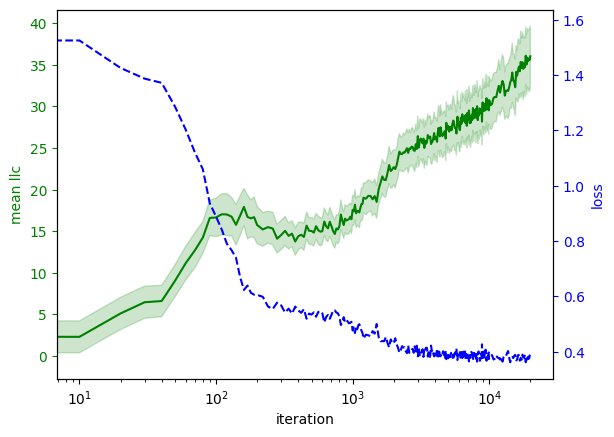

In [17]:
x = iters
y = [llc["llc/means"].mean() for llc in llcs]
y_err = [llc["llc/stds"].mean() for llc in llcs]
y_loss = [llc["init_loss"] for llc in llcs]
# plt.plot(x, y)

# plot x and y_loss with a scale on the right side
fig, ax1 = plt.subplots()
ax1.plot(x, y, 'g-')
#fill between
ax1.fill_between(x, [y[i] - y_err[i] for i in range(len(y))], [y[i] + y_err[i] for i in range(len(y))], color='g', alpha=0.2)
ax1.set_xlabel('iteration')
ax1.set_ylabel('mean llc', color='g')
ax1.tick_params('y', colors='g')

ax2 = ax1.twinx()
ax2.plot(x, y_loss, 'b--')
ax2.set_ylabel('loss', color='b')
ax2.tick_params('y', colors='b')

# set x axis to log scale
plt.xscale('log')
# plt.xlim([10, 1200])

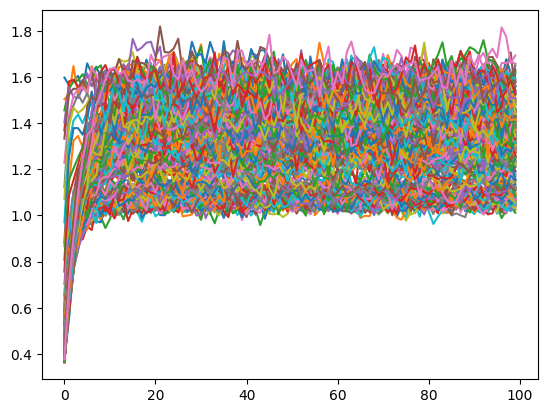

In [18]:
llc_traces = [llc["loss/trace"] for llc in llcs]
# meaned_traces = llc_traces.mean(axis=1)
meaned_traces = [np.mean(llc_traces, axis=0) for llc_traces in llc_traces]

for trace in meaned_traces:
    plt.plot(trace)
    # plt.legend(iters, loc='center left', bbox_to_anchor=(1, 0.5))

1.5871301 +/- 0.21911116


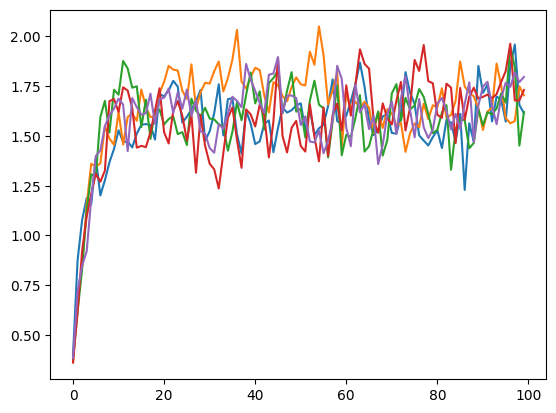

In [19]:
idx = -1
for trace in llc_traces[idx]:
    plt.plot(trace)

print(llc_traces[idx][-1].mean(), "+/-", llc_traces[idx][-1].std())